# Customer Life Time Value(CLTV): Müşteri Yaşam Boyu değeri

**Bir müşterinin bir firmayla olan tüm ilişki süresi boyunca firmadan yapacağı satın almaların beklenen karının bugünkü değerini göz önünde bulunduran müşteri yasam boyu değeri, işletmelerin en yüksek ve en düşük karlı müşterilerini tanımlayarak pazarlama strateji ve taktiklerine bu doğrultuda yön vermesini sağlayan bir ölçümdür.**


* #### CLTV = (Customer_Value / Churn_Rate) x Profit_margin.
* #### Customer_Value = Average_Order_Value * Purchase_Frequency
* #### Average_Order_Value = Total_Revenue / Total_Number_of_Orders
* #### Purchase_Frequency =  Total_Number_of_Orders / Total_Number_of_Customers
* #### Churn_Rate = 1 - Repeat_Rate
* #### Profit_margin : 


In [6]:

import pandas as pd

pd.set_option('display.max_columns', 20)
# pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [7]:
df_ = pd.read_excel("online_retail_II.xlsx",
                    sheet_name="Year 2009-2010")
df = df_.copy()

In [8]:
# Verideki eksik ya da istenmeeyn gözlemleri attım
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[(df['Quantity'] > 0)]
df.dropna(inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [9]:
df.shape

(407695, 8)

## Veri Ön İşleme

**Veri seti alınan her bir ürüne ait bilgileri içeirmektedir. CLTV müşterileri baz alan bir heseapalama olduğu için veri setini müşteri bilgisine göre düzenlemek gerekmektedir**

In [10]:
# Her gözlemde ürünlerin alınan miktarları ile birim fiyatlrı çarpılıp her gözlem için toplam fiyatı hesapladım
df["TotalPrice"] = df["Quantity"]*df["Price"]

In [11]:
# Veriyi müşteri özeline çevirmemiz gerekli
# her bir müşteri kaç kez alışveriş yaptı, ne kadar miktarda ürün aldı  ve ne kadar para bıraktı
cltv_df = df.groupby("Customer ID").agg({"Invoice": lambda x:len(x),
                                         "Quantity": lambda x: x.sum(),
                                         "TotalPrice": lambda x : x.sum()})

cltv_df.columns = ['total_transaction', 'total_unit', 'total_price']
cltv_df.head()

,total_transaction,total_unit,total_price
Customer ID,,,
12346.00000,33,70,372.86000
12347.00000,71,828,1323.32000
12348.00000,20,373,222.16000
12349.00000,102,993,2671.14000
12351.00000,21,261,300.93000


In [12]:
cltv_df.sort_values("total_price")

,total_transaction,total_unit,total_price
Customer ID,,,
14827.00000,1,5,0.00000
14103.00000,1,5,0.00000
14095.00000,1,1,2.95000
13788.00000,1,1,3.75000
15913.00000,1,3,6.30000
...,...,...,...
13694.00000,957,125893,131443.19000
14911.00000,5570,69722,152147.57000
14156.00000,2648,108107,196566.74000


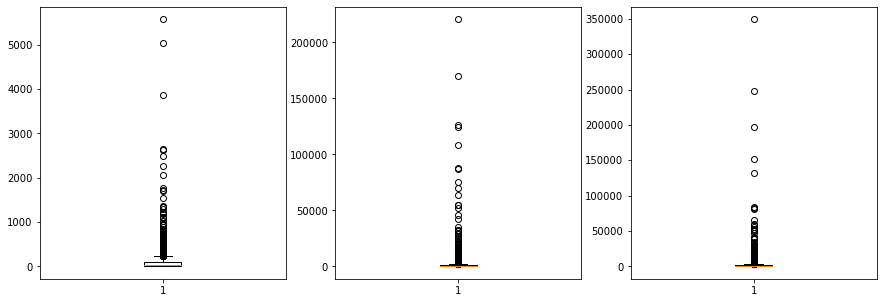

In [13]:
fig,ax=plt.subplots(1,3, figsize=(15,5))
ax[0].boxplot(cltv_df["total_transaction"]);
ax[1].boxplot(cltv_df["total_unit"]);
ax[2].boxplot(cltv_df["total_price"]);

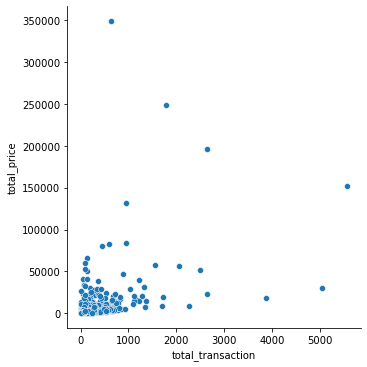

In [14]:
sns.relplot("total_transaction", "total_price", data =cltv_df)

## CLTV Hesaplama


In [15]:
# Ortalama sipariş değeri: Toplam ödediği miktarın toplam yaptığı alışverişe oranı=alışveriş başına ortalama bırakılan para
cltv_df['avg_order_value'] = cltv_df["total_price"]/cltv_df["total_transaction"]

# Bir müşterinin sipariş sayısının toplam müşteri sayısına oranı alışveriş sıklığını vermektedir.
cltv_df["purchase_frequency"] = cltv_df["total_transaction"]/cltv_df.shape[0]


In [16]:
# Repeat rate: Toplam alışverişi sayısı birden fazla olan müşterilerin oranıı
repeat_rate = cltv_df[cltv_df["total_transaction"]>1].shape[0]/cltv_df.shape[0]

# Curn rate: sadece bir kez alışveriş yapmış müşterilerin oranını vermektedir. Daolayısı ile 1-repeat_rate 
churn_rate = 1-repeat_rate


In [17]:
# Kar marjı: bir müşterinin toplam bıraktığı paranın belli bir yüzdesidir. Bu yüzde firma politikalarına göre değişebilir
cltv_df["profit_margin"] = cltv_df["total_price"]*0.05


In [18]:
# Customer Value: Müşteirnin sipariş başına ortalama bıraktığı para ile satış sıklığı değerlerinin çarpılması
cltv_df["CV"] = cltv_df["avg_order_value"]*cltv_df["purchase_frequency"]


In [19]:
# Customer LT Value: Müşteir değeri ile profit marjinlerinin çarpılıp, müşteri kayıp oranına bölünmesi
cltv_df["CLTV"] = (cltv_df["CV"]/churn_rate)*cltv_df["profit_margin"]


In [20]:
cltv_df["purchase_frequency"].sum()

94.50509967547521

In [21]:
cltv_df

,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV
Customer ID,,,,,,,,
12346.00000,33,70,372.86000,11.29879,0.00765,18.64300,0.08643,74.74440
12347.00000,71,828,1323.32000,18.63831,0.01646,66.16600,0.30675,941.49238
12348.00000,20,373,222.16000,11.10800,0.00464,11.10800,0.05150,26.53498
12349.00000,102,993,2671.14000,26.18765,0.02364,133.55700,0.61918,3836.01554
12351.00000,21,261,300.93000,14.33000,0.00487,15.04650,0.06976,48.68756
...,...,...,...,...,...,...,...,...
18283.00000,230,336,641.77000,2.79030,0.05331,32.08850,0.14876,221.43480
18284.00000,28,494,461.68000,16.48857,0.00649,23.08400,0.10702,114.59593
18285.00000,12,145,427.00000,35.58333,0.00278,21.35000,0.09898,98.02634


<AxesSubplot:>

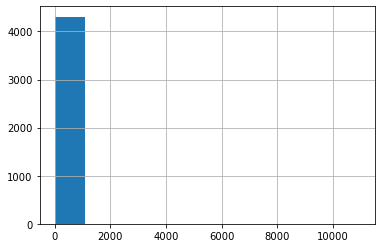

In [22]:
cltv_df["avg_order_value"].hist()

## Ölçeklendirme ve Segmentasyon

* **Hesaplanan CLTV değerlerini  daha sağlıklı yorumlanabilmes için ölçeklendirme yapıyoruz. 1-100 arasına ölçekledireceğiz**
* **Müşteirle hesaplanan CLTV değerlerine göre segmentlere ayrıp gruplamaya çalışacağım**

In [23]:
# minimum değere 1 ve maksimum değere 100 olacak şekilde ölçeklendirme yapılıyor
scaler = MinMaxScaler(feature_range=(1, 100))
scaler.fit(cltv_df[["CLTV"]])
cltv_df["SCALED_CLTV"] = scaler.transform(cltv_df[["CLTV"]])


<AxesSubplot:>

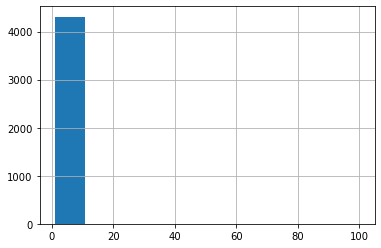

In [24]:
cltv_df["SCALED_CLTV"].hist()

<AxesSubplot:ylabel='SCALED_CLTV'>

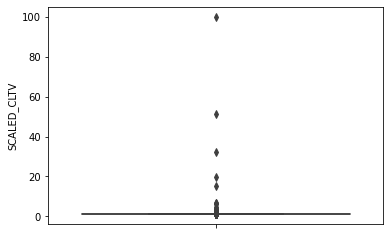

In [25]:
sns.boxplot(y =cltv_df["SCALED_CLTV"])

In [26]:
cltv_df["SCALED_CLTV"].mean()

1.067891140071159

* **1 ile 100 arasına ölçeklendirdik.1' de aşırı bir toplanma var, ve genel duruma göre oldukça aykırılık söz konusu, Tabi ki de bu aykırılık olumsuz anlam taşumamaktadır**

In [49]:
cltv_df["SCALED_CLTV"].describe()

count   4314.00000
mean       1.06789
std        1.80088
min        1.00000
25%        1.00008
50%        1.00040
75%        1.00241
max      100.00000
Name: SCALED_CLTV, dtype: float64

In [54]:
# Müşteirle CLTV değeri aralıklarına göre anlamlı şekilde gruplara ayrılması
cltv_df["Segment"] = pd.cut(cltv_df["SCALED_CLTV"],bins=[0.99,1.0009,1.05,100] , labels=[ "C", "B", "A"])

<AxesSubplot:xlabel='Segment', ylabel='count'>

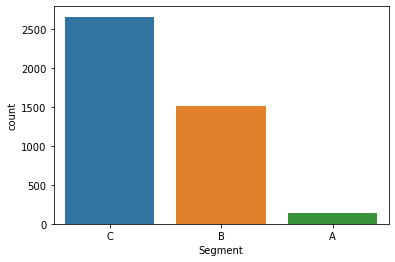

In [55]:
sns.countplot(cltv_df["Segment"])

In [56]:
cltv_df["Segment"].value_counts()

C    2655
B    1515
A     144
Name: Segment, dtype: int64

<AxesSubplot:xlabel='Segment', ylabel='SCALED_CLTV'>

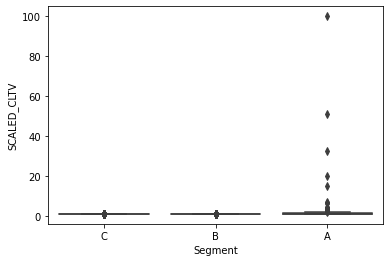

In [57]:
sns.boxplot(cltv_df["Segment"], cltv_df["SCALED_CLTV"])

In [59]:
cltv_df.sort_values("SCALED_CLTV")

,total_transaction,total_unit,total_price,avg_order_value,purchase_frequency,profit_margin,CV,CLTV,SCALED_CLTV,Segment
Customer ID,,,,,,,,,,
14827.00000,1,5,0.00000,0.00000,0.00023,0.00000,0.00000,0.00000,1.00000,C
14103.00000,1,5,0.00000,0.00000,0.00023,0.00000,0.00000,0.00000,1.00000,C
14095.00000,1,1,2.95000,2.95000,0.00023,0.14750,0.00068,0.00468,1.00000,C
13788.00000,1,1,3.75000,3.75000,0.00023,0.18750,0.00087,0.00756,1.00000,C
15913.00000,1,3,6.30000,6.30000,0.00023,0.31500,0.00146,0.02134,1.00000,C
...,...,...,...,...,...,...,...,...,...,...
13694.00000,957,125893,131443.19000,137.34921,0.22184,6572.15950,30.46898,9288877.52547,15.02980,A
14911.00000,5570,69722,152147.57000,27.31554,1.29115,7607.37850,35.26833,12445636.05210,19.79773,A
14156.00000,2648,108107,196566.74000,74.23215,0.61382,9828.33700,45.56484,20773378.10442,32.37585,A


<AxesSubplot:xlabel='Segment', ylabel='SCALED_CLTV'>

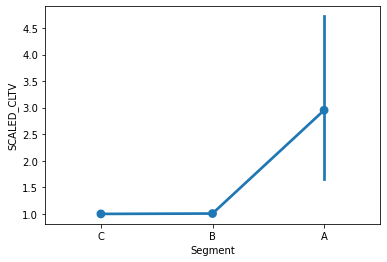

In [60]:
# Segmenlerin Ortalaması
sns.pointplot(x=cltv_df["Segment"], y=cltv_df["SCALED_CLTV"])